---
title: "Practice Activity – 9.1 (Linear Classifiers)"
author: "Shiqi Wu"
format:
  html:
    self-contained: true      
    toc: true
    code-fold: false
    theme: cosmo              
jupyter: python3
execute:
  echo: true
  warning: false
  message: false
---

**Repository:** [Practice Activity 9.1](https://github.com/shiqiwu212/GSB-S544-01/tree/ba29aab9506a4c93d7e72552ede260449eb2e438/Week%209/Practice%20Activities/Practice%20Activity%209.1)

## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [36]:
# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression        
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA  
from sklearn.svm import SVC                                
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Read dataset
df = pd.read_csv("ha_1 .csv")
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [3]:
TARGET_CANDIDATES = ["target","label","y","class","outcome","disease","ha","heart_attack"]
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), df.columns[-1])

In [9]:
X = df[["age","chol"]].astype(float)
y_raw = df[target_col].astype(str).str.strip()
y = y_raw.map({
    "Disease": 1, "Heart Disease": 1, "Present": 1, "Yes": 1, "Positive": 1, "1": 1,
    "No Disease": 0, "Absent": 0, "No": 0, "Negative": 0, "Healthy": 0, "0": 0
}).astype(int)

In [10]:
logit = LogisticRegression(max_iter=1000)
logit.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
#AI help with this part
def chol_threshold_for_p(model, age_fixed, p_target, chol_min=None, chol_max=None, step=0.1):
    if chol_min is None: chol_min = float(X["chol"].min())
    if chol_max is None: chol_max = float(X["chol"].max())
    grid = np.arange(chol_min, chol_max + step, step)
    Xgrid = pd.DataFrame({"age": np.full_like(grid, age_fixed, dtype=float),
                          "chol": grid})
    classes = list(model.classes_)           # ensure we select prob for positive class = 1
    pos_idx = classes.index(1)
    p = model.predict_proba(Xgrid)[:, pos_idx]
    meets = np.where(p >= p_target)[0]
    return float(grid[meets[0]]) if meets.size else np.nan

In [13]:
age_fixed = 55
thr_50 = chol_threshold_for_p(logit, age_fixed=age_fixed, p_target=0.50, step=0.1)
thr_90 = chol_threshold_for_p(logit, age_fixed=age_fixed, p_target=0.90, step=0.1)

print(f"[Logistic] At age {age_fixed}:")
print(f"  Chol threshold for predicted disease (p >= 0.50): {thr_50:.1f}")
print(f"  Chol threshold for 90% chance (p >= 0.90):       {thr_90:.1f}")

[Logistic] At age 55:
  Chol threshold for predicted disease (p >= 0.50): 126.0
  Chol threshold for 90% chance (p >= 0.90):       nan


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [14]:
# Reuse X, y from above; fit LDA
lda = LDA()
lda.fit(X, y)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


In [16]:
# AI help with this part
def chol_threshold_for_p_lda(model, age_fixed, p_target=0.50, chol_min=None, chol_max=None, step=0.1):
    if chol_min is None: chol_min = float(X["chol"].min())
    if chol_max is None: chol_max = float(X["chol"].max())
    grid = np.arange(chol_min, chol_max + step, step)
    Xgrid = pd.DataFrame({"age": np.full_like(grid, age_fixed, dtype=float),
                          "chol": grid})
    classes = list(model.classes_)           # positive class = 1
    pos_idx = classes.index(1)
    p = model.predict_proba(Xgrid)[:, pos_idx]
    meets = np.where(p >= p_target)[0]
    return float(grid[meets[0]]) if meets.size else np.nan

age_fixed = 55
thr_pred = chol_threshold_for_p_lda(lda, age_fixed=age_fixed, p_target=0.50, step=0.1)

print(f"[LDA] At age {age_fixed}:")
print(f"  Chol threshold for predicted disease (p >= 0.50): {thr_pred:.1f}")

[LDA] At age 55:
  Chol threshold for predicted disease (p >= 0.50): 126.0


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [24]:
# Pipeline: Standardize -> Linear SVC (enable probability for later use if needed)
svc_pipe = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True))

In [25]:
# Minimal tuning on C (lecture-style small grid)
param_grid = {"svc__C": [0.01, 0.1, 1, 10, 100]}
svc_grid = GridSearchCV(svc_pipe, param_grid=param_grid, cv=5)
svc_grid.fit(X, y)

,estimator,Pipeline(step...ility=True))])
,param_grid,"{'svc__C': [0.01, 0.1, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [26]:
svc_best = svc_grid.best_estimator_
best_C = svc_grid.best_params_["svc__C"]
print("Best C for SVC:", best_C)

Best C for SVC: 10


In [ ]:
# AI help with this part:
# Threshold: first cholesterol where class prediction becomes 1 at age=55
def chol_threshold_for_pred(model, age_fixed, chol_min=None, chol_max=None, step=0.1):
    if chol_min is None: chol_min = float(X["chol"].min())
    if chol_max is None: chol_max = float(X["chol"].max())
    grid = np.arange(chol_min, chol_max + step, step)
    Xgrid = pd.DataFrame({"age": np.full_like(grid, age_fixed, dtype=float),
                          "chol": grid})
    yhat = model.predict(Xgrid)          # 0/1
    idx = np.where(yhat == 1)[0]
    return float(grid[idx[0]]) if idx.size else np.nan

age_fixed = 55
thr_svc = chol_threshold_for_pred(svc_best, age_fixed=age_fixed, step=0.1)
print(f"[SVC] At age {age_fixed}: Chol threshold for predicted disease: {thr_svc:.1f}")

[SVC] At age 55: Chol threshold for predicted disease: 126.0


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [28]:
# Ai help with this:
# Helper: compute line y_chol(x_age) from linear model w·x + b = 0  =>  chol = -(w_age*age + b)/w_chol
def boundary_line_from_coef(coef, intercept, x_vals):
    w_age, w_chol = coef
    b = intercept
    # Avoid division by zero if w_chol≈0
    eps = 1e-12 if abs(w_chol) < 1e-12 else 0.0
    return -(w_age * x_vals + b) / (w_chol + eps)

In [ ]:
# Coefs for Logistic & LDA 
w_logit = logit.coef_[0]
b_logit = logit.intercept_[0]
w_lda   = lda.coef_[0]
b_lda   = lda.intercept_[0]

In [30]:
# Coefs for SVC are in standardized space; convert back to original units
scaler = svc_best.named_steps["standardscaler"]
svc_clf = svc_best.named_steps["svc"]
w_svc_std = svc_clf.coef_[0]
b_svc_std = svc_clf.intercept_[0]

In [31]:
# Transform: w_orig = w_std / scale ; b_orig = b_std - sum(w_std * mean/scale)
w_svc = w_svc_std / scaler.scale_
b_svc = b_svc_std - np.sum(w_svc_std * (scaler.mean_ / scaler.scale_))

In [35]:
# X-range for the lines
x_min, x_max = float(X["age"].min()), float(X["age"].max())
x_vals = np.linspace(x_min, x_max, 200)

y_logit = boundary_line_from_coef(w_logit, b_logit, x_vals)
y_lda   = boundary_line_from_coef(w_lda,   b_lda,   x_vals)
y_svc   = boundary_line_from_coef(w_svc,   b_svc,   x_vals)

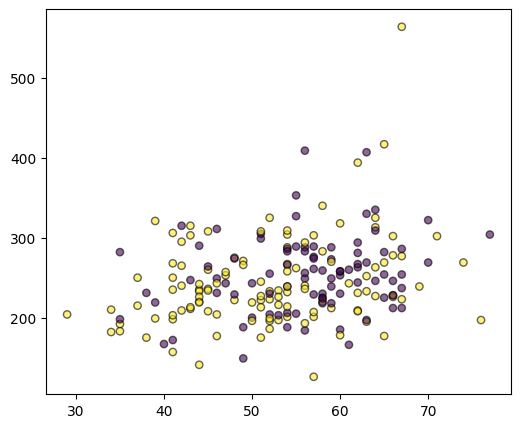

In [37]:
# Scatter of true points
plt.figure(figsize=(6,5))
plt.scatter(X["age"], X["chol"], c=y, alpha=0.6, edgecolor="k", s=28)